**Data Science and AI for Energy Systems** 

Karlsruhe Institute of Technology

Institute of Automation and Applied Informatics

Summer Term 2024

---

# Exercise XI: Physics inspired neural networks (PINN)

**Imports**

In [1]:
!pip install pyDOE

In [12]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import scipy as sc

import pyDOE #not yet in the docker

## Problem XI.2 (Programming) -- Physics informed neural network - Swing equation

**We consider a 1-node-infinite bus system
\begin{align}\nonumber
    \frac{d\theta}{dt}&=\omega(t)\\
    \frac{d\omega}{dt}&=P-c\omega(t) - K\sin (\theta(t)),
\end{align}
or equivalently given as 
\begin{align*}
    \frac{d^2\theta}{dt^2}(t)&=P-c\frac{d\theta}{dt}(t) - K\sin (\theta(t)). 
\end{align*}
We want to construct a physics-informed neural network (PINN) in order to find the solution of the ODE (respective the values of $\theta$ and $\omega$). This method can be used as an alternative to classical numerical calculations. The physics-informed neural network which we use and complete in this exercise is adapted from  [Misyris et al.](https://ieeexplore.ieee.org/abstract/document/9282004) and [Raissi et al](https://www.sciencedirect.com/science/article/pii/S0021999118307125). We use time $t$ and power feed in $P$ as inputs. As output of our PINN we want to receive predictions for $\theta$ and for the ODE equation 
\begin{align*}
\frac{d^2\theta}{dt^2} - P + c\frac{d\theta}{dt} + K\sin (\theta) &= 0,
\end{align*}
where we fix $c=0.5$ and $K=1$.**

**The target data for the PINN is calculated with a numerical ODE-solver as in Exercise III.2:**

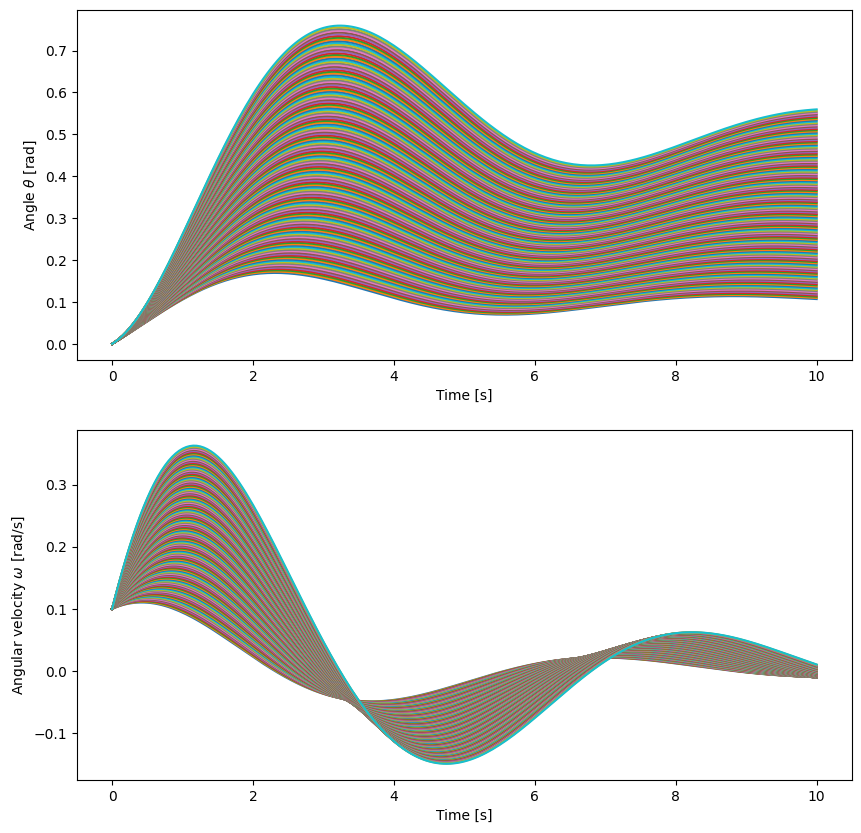

In [7]:
K = 1
c = 0.5

initial_conditions_nonlinear = [0.,0.1]

def one_node_infinite_bus(x, t, P, c, K):
    x1,x2 = x
    return [x2,P - c*x2 - K*np.sin(x1)]

P_range = np.arange(0.1,K-0.5,0.0025) 
t = np.linspace(0, 10, 201)
theta_target = np.zeros((len(P_range),len(t)))
omega_target = np.zeros((len(P_range),len(t)))
for i,P in enumerate(P_range):
    #solve the ODE for each value of P
    sol_non_lin = sc.integrate.odeint(one_node_infinite_bus, y0=initial_conditions_nonlinear, t=t,args=(P,c,K))
    theta_target[i,:] = sol_non_lin[:,0]
    omega_target[i,:] = sol_non_lin[:,1]

fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(t,theta_target.T)
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel(r'Angle $\theta$ [rad]')
ax[1].plot(t,omega_target.T)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Angular velocity $\omega$ [rad/s]')
plt.show()

***
**(a) We use a feedforward neural network (FNN) as basis for the physics-informed neural network. Complete the class for a FNN with 5 layers (one input layer, 3 hidden layers and one output layer), where the number of neurons is given by [2,20,20,20,1] (in the order of the layers). For our class we inherit *torch.nn.Module*.**

*Note that we don't do a hyperparameter tuning in the exercise for reasons of simplicity. Possible adaptable hyperparameters are for example the number of layers and the number of neurons per layer, the choice for the activation function and the optimizer.*

As activation for the hidden layers, use the tangens hyperbolicus (*torch.nn.Tanh*); for the output layer, we use just a linear layer.

In [281]:
# define a feedforward neural network (dense network)
class DNN(torch.nn.Module):
  def __init__(self):
    super(DNN, self).__init__()

    self.layer_1 = torch.nn.Linear(2, 20)
    ??? add the other layers here ???


  def forward(self, x):
    ??? # add the forward function here ( linear -> activation -> linear -> activation -> ... -> linear)

    return x

For parts (b) - (d), you can complete the class *PhysicsInformedNN* (see below after (d))

***
**(b) We define the class *PhysicsInformedNN* for the physics-informed neural network, which extends the previously defined FNN. Write a function for the point estimates $\hat{\theta}$ of $\theta$ as output of the FNN and include it in the class *PhysicsInformedNN*.**

***
**(c) Write a function for the residual ODE, i.e. the  physical constraints.**

***
**(d) Add a loss function; we want to use a sum of a mean-squared error for the labeled data loss and for
the physical constraints each. Include also weights for the two losses such that you can
weight the two loss functions differently.**

In [282]:
# the physics-guided neural network
class PhysicsInformedNN(torch.nn.Module):
    def __init__(self, X_u, u, X_f, lb, ub, c, K, ???, ???):
        super(PhysicsInformedNN, self).__init__()
        # boundary conditions
        self.lb = torch.tensor(lb).float()
        self.ub = torch.tensor(ub).float()
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float()
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float()
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float()
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float()
        self.u = torch.tensor(u).float()
        

        self.c = c
        self.K = K
        self.scale_data = ??? # part (d)
        self.scale_physics = ??? # part (d)
        
        # deep neural networks
        self.dnn = DNN() # (layers)
        
        '''
        Optimizer:
        we use the L-BFGS optimizer 
        (optimization algorithm in the family of quasi-Newton methods that approximates the 
        Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory.)
        Details: https://towardsdatascience.com/numerical-optimization-based-on-the-l-bfgs-method-f6582135b0ca
        '''
        self.optimizer = torch.optim.LBFGS( 
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=500,  
            max_eval=500,  
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe" 
        )
        # self.optimizer = torch.optim.Adam(self.dnn.parameters())

        self.iter = 0
        
    def output_theta(self, x, t):
        
        ??? # Part (b); Hint: use the dnn to predict the output, as input use the concatenation of x and t

        return theta

    '''
    As an auxiliary function and as a comparison function, we define a function that outputs the derivative of theta, 
    called omega. The derivative is calculated using automatic differentiation of theta with respect to t.
    '''
    def output_omega(self, x, t): 
        theta = self.output_theta(x, t)
        omega = torch.autograd.grad(theta, t, grad_outputs=torch.ones_like(theta), retain_graph=True, create_graph=True)[0] 
        # use autograd to calculate the gradient via automatic defferentiation
        return omega
    
    def output_residual_ode(self,x,t):
        
        ??? # Part (c); Hint: Write the formula for the residual ODE  using the the functions output_theta and output_omega
        
        return residual_ode
    
    def loss_func(self): #???
        self.optimizer.zero_grad()
        
        data_pred = self.output_theta(self.x_u, self.t_u)
        ode_pred = self.output_residual_ode(self.x_f, self.t_f)
        
        ??? # Part (d); Hint: Write the loss function using mean-squarer-error-losses for the prediction $\theta$ and the residual ODE
        # Include also the scaling factors for the data and the physics loss in the loss function and as parameters for the class
        loss_data = ???
        loss_physics = ???
        loss = ???
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0: #print the loss during the training
            print(
                'Iter %d, Loss: %.5e, Loss_data: %.5e, Loss_phys/Loss_f: %.5e' % (self.iter, loss.item(), loss_data.item(), loss_physics.item())
            )
        return loss
    # define the training function
    def train(self): # 
        self.dnn.train()
        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def forward(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float()
        t = torch.tensor(X[:, 1:2], requires_grad=True).float()

        theta = self.output_theta(x, t)
        f = self.output_residual_ode(x, t)
        omega = self.output_omega(x, t)
        theta = theta.detach().numpy()
        f = f.detach().numpy()
        omega = omega.detach().numpy()
        return theta, f, omega

    def predict(self, X):
        return self.forward(X)


***
**(e) Train the model using both losses equally weighted (both weights = 1) for a given training set, and run the prediction, using the combination of each time step and each choice of power input $P$ that were used in the construction of the target data as  input. Print the loss, and plot some of the predictions as well as the ground truth data.**

Note that for the training data we use initial and boundary values which are taken from the numerically solved solution which was calculated at the beginning. For the physics-informed loss we use a certain number of "collocation points" where we evaluate the residual ODE. 

In [283]:
'''
We define the datasets for training and testing the model. 
Not
'''

N_u = 50 #number of training points (x,t), where the tarhet value theta(t) is known
N_f = 1000 #number of points (x,t), where the ODE is evaluated 

x = P_range # we use the power feed-in P as state variable
# Reminder: P_range = np.arange(0.1,K-0.5,0.0025), t = np.linspace(0, 10, 201)

exact_data = theta_target.T #the target data for the training is the angle theta(t) for each value of P 
'''
we use the values for theta which where calculated via numerical integration at the top of the Notebook as target data
'''

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #each combination of t and P
theta_star = exact_data.flatten()[:,None]              

# Domain bounds
lb = X_star.min(0) #lower bount of t and x
ub = X_star.max(0) #upper bound for t and x   

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) # initial condition
uu1 = exact_data[0:1,:].T # initial condition
xx2 = np.hstack((X[:,0:1], T[:,0:1])) # boundary condition
uu2 = exact_data[:,0:1] # boundary condition
xx3 = np.hstack((X[:,-1:], T[:,-1:])) # boundary condition
uu3 = exact_data[:,-1:] # boundary condition

# combine initial and boundary conditions:
X_u_train = np.vstack([xx1, xx2, xx3]) 
u_train = np.vstack([uu1, uu2, uu3])
# select N_u random points from the boundary and initial conditions and the according data ponts (theta)
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_f_train = lb + (ub-lb)*pyDOE.lhs(2, N_f) # select N_f random points in the domain for t and x

In [284]:
# Select the model:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train,...???)
# Train the model:
???

Iter 100, Loss: 6.13112e-04, Loss_u: 2.92917e-04, Loss_f: 3.20195e-04
Iter 200, Loss: 3.90486e-04, Loss_u: 1.50578e-04, Loss_f: 2.39908e-04
Iter 300, Loss: 2.85719e-04, Loss_u: 9.09187e-05, Loss_f: 1.94801e-04
Iter 400, Loss: 1.52838e-04, Loss_u: 3.88754e-05, Loss_f: 1.13963e-04
Iter 500, Loss: 7.02356e-05, Loss_u: 1.98332e-05, Loss_f: 5.04024e-05


In [294]:
# Predict the results for the whole domain
theta_pred, f_pred, omega_pred = model.predict(X_star)

error_theta = np.linalg.norm(theta_star-theta_pred,2)/np.linalg.norm(theta_star,2)
print('Relative error theta: %e' % (error_theta))                     

# bring the data in the right shape for comparing the results to the target data
theta_pred = sc.interpolate.griddata(X_star, theta_pred.flatten(), (X, T), method='cubic').T
omega_pred = sc.interpolate.griddata(X_star, omega_pred.flatten(), (X, T), method='cubic').T

Error theta: 2.796968e-02


In [302]:
# plot the results for the dynamics of theta and its derivative omega for 10 random values of P
P_random = np.random.choice(theta_pred.shape[0], 10, replace=False)

In [303]:
for i in P_random: 
    ??? #plot the results for the predictions and the target data of omega for the selected values of P
    plt.show()

Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the 

In [304]:
# analogously plot the results for omega
for i in P_random: 
    #??? #plot the results for the predictions and the target data of theta for the selected values of P
    plt.show()

***
**(f) Train the model using the data-driven loss only (data-driven loss = 1, physics-informed loss = 0). Run the prediction as in (d), print the loss, and plot some of the predictions as well as the ground truth data. What can you observe?**

In [217]:
# Select and train the model
???

Iter 100, Loss: 8.08366e-04, Loss_u: 8.08366e-04, Loss_f: 1.36150e-02
Iter 200, Loss: 4.54315e-04, Loss_u: 4.54315e-04, Loss_f: 2.19893e-02
Iter 300, Loss: 1.86981e-04, Loss_u: 1.86981e-04, Loss_f: 3.62497e-02
Iter 400, Loss: 6.98270e-05, Loss_u: 6.98270e-05, Loss_f: 9.34347e-03
Iter 500, Loss: 1.22147e-05, Loss_u: 1.22147e-05, Loss_f: 2.47169e-03


In [10]:
# Predict the results for the whole domain
theta_pred, f_pred, omega_pred = model.predict(X_star)

error_theta = np.linalg.norm(theta_star-theta_pred,2)/np.linalg.norm(theta_star,2)
print('Relative error theta: %e' % (error_theta))                     

# bring the data in the right shape for comparing the results to the target data
theta_pred = sc.interpolate.griddata(X_star, theta_pred.flatten(), (X, T), method='cubic').T
omega_pred = sc.interpolate.griddata(X_star, omega_pred.flatten(), (X, T), method='cubic').T

In [220]:
for i in P_random: 
    ??? #plot the results for the predictions and the target data of theta for the selected values of P
    plt.show()

In [ ]:
# analogously plot the results for omega
for i in P_random: 
    ??? #plot the results for the predictions and the target data of omega for the selected values of P
    plt.show()

***
**(g) Repeat the steps from (d) and (e) choosing only the physical loss.**

In [ ]:
# Select and train the model
???

In [223]:
# Predict the results for the whole domain
theta_pred, f_pred, omega_pred = model.predict(X_star)

error_theta = np.linalg.norm(theta_star-theta_pred,2)/np.linalg.norm(theta_star,2)
print('Relative error theta: %e' % (error_theta))                     

# bring the data in the right shape for comparing the results to the target data
theta_pred = sc.interpolate.griddata(X_star, theta_pred.flatten(), (X, T), method='cubic').T
omega_pred = sc.interpolate.griddata(X_star, omega_pred.flatten(), (X, T), method='cubic').T

Iter 100, Loss: 4.84773e-06, Loss_u: 1.88254e-02, Loss_f: 4.84773e-06
Iter 200, Loss: 4.40779e-07, Loss_u: 1.90480e-02, Loss_f: 4.40779e-07
Error u: 3.222408e-01


In [305]:
for i in P_random: 
    ??? #plot the results for the predictions and the target data of theta for the selected values of P
    plt.show()

Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the target data of theta for the selected values of P` not found.
Object `? #plot the results for the predictions and the 

In [306]:
# analogously plot the results for omega
for i in P_random: 
    ??? #plot the results for the predictions and the target data of omega for the selected values of P
    plt.show()

## Problem XI.3 (Programming) -- Physics informed neural network - Swing equation - parameter identification

**In this exercise we again consider the 1-node-infinite-bus system as in XI.2, but this time we want to estimate the parameters $c$ and $K$, instead of only trying to find the dynamics of $\theta$. We use the same model as in XI.2 (you can for example inherit the class *PhysicsInformedNN*).**

***
**(a) Set up initial values for the parameters $c=1.2$ and $K=1.8$ in the model and add them as trainable parameters to the neural network.**

We define a new class by inheriting the class *PhysicsInformedNN*: 

In [309]:
class PhysicsInformedNN_identify_params(PhysicsInformedNN):
    def __init__(self,X_u, u, X_f, lb, ub, scale_data, scale_physics):
        super(PhysicsInformedNN_identify_params, self).__init__(X_u, u, X_f, lb, ub, scale_data, scale_physics)
        
        # deep neural network
        self.dnn = DNN()
        
        ??? # Part (a); Hint: Define the parameters c and K as torch parameters and register them in the dnn (use dnn.register_parameter)

        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=1000,  # we use more uterations for the optimization
            max_eval=1000,  
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe" )

***
**(b) Remember that we used the values K = 1 and c = 0.5 as parameters for the target values. Train the model (set both weights for the losses to 1), and run the prediction of the model for the full input dataset. Print the loss, and plot the predictions. What are the values of the estimated $\hat{c}$ and $\hat{K}$, and how large is the  error between the predictions and the true parameters?**

In [310]:
# Select and train the model
???

Object `? # Part (a); Hint: Define the parameters c and K as torch parameters and register them in the dnn (use dnn.register_parameter)` not found.
Iter 100, Loss: 1.23039e-03, Loss_u: 9.81859e-04, Loss_f: 2.48529e-04
Iter 200, Loss: 4.83898e-04, Loss_u: 2.72305e-04, Loss_f: 2.11593e-04
Iter 300, Loss: 3.81602e-04, Loss_u: 1.85788e-04, Loss_f: 1.95814e-04
Iter 400, Loss: 3.21617e-04, Loss_u: 1.51928e-04, Loss_f: 1.69688e-04
Iter 500, Loss: 2.54505e-04, Loss_u: 1.16502e-04, Loss_f: 1.38004e-04
Iter 600, Loss: 9.85542e-05, Loss_u: 2.91534e-05, Loss_f: 6.94008e-05
Iter 700, Loss: 5.14338e-05, Loss_u: 1.44548e-05, Loss_f: 3.69791e-05
Iter 800, Loss: 2.87224e-05, Loss_u: 7.74532e-06, Loss_f: 2.09771e-05
Iter 900, Loss: 2.23388e-05, Loss_u: 4.13319e-06, Loss_f: 1.82056e-05
Iter 1000, Loss: 1.72465e-05, Loss_u: 4.44493e-06, Loss_f: 1.28016e-05


In [9]:
# Predict the results for the whole domain
theta_pred, f_pred, omega_pred = model.predict(X_star)

error_theta = np.linalg.norm(theta_star-theta_pred,2)/np.linalg.norm(theta_star,2)
print('Relative error theta: %e' % (error_theta))                     

# bring the data in the right shape for comparing the results to the target data
theta_pred = sc.interpolate.griddata(X_star, theta_pred.flatten(), (X, T), method='cubic').T
omega_pred = sc.interpolate.griddata(X_star, omega_pred.flatten(), (X, T), method='cubic').T

# Print the predicted parameters c and K and the relative error to the true values
???

In [ ]:
for i in P_random: 
    ??? #plot the results for the predictions and the target data of theta for the selected values of P
    plt.show()

In [ ]:
# analogously plot the results for omega
for i in P_random: 
    ??? #plot the results for the predictions and the target data of omega for the selected values of P
    plt.show()